In [1]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array, hex_array
from hera_filters import dspec
from jax import numpy as jnp
from hera_cal import abscal, redcal, datacontainer, apply_cal
from stefcal import calibration
from copy import deepcopy
import jax
from hera_sim import vis, utils
from scipy import stats
jax.config.update("jax_enable_x64", True)
%matplotlib notebook
%load_ext line_profiler

In [70]:
nfreqs = 1500
freqs = np.linspace(50e6, 250e6, nfreqs)
antpos = hex_array(6, split_core=True)
reds = redcal.get_reds(antpos, pols=['nn', 'ee'])

gains = {
    (k, 'Jnn'): np.random.normal(1, 0.1, size=(1, nfreqs)) * np.exp(-1j * np.random.uniform(0, 0.25 * np.pi, (1, nfreqs)))
    for k in antpos
}
gains.update({
    (k, 'Jee'): np.random.normal(1, 0.1, size=(1, nfreqs)) * np.exp(-1j * np.random.uniform(0, 0.25 * np.pi, (1, nfreqs)))
    for k in antpos
})

_gains, model_vis, data_vis = vis.sim_red_data(reds, shape=(1, nfreqs), gains=gains)
model_vis = datacontainer.RedDataContainer(model_vis, reds=reds)
data_vis = datacontainer.DataContainer(data_vis)


noise_scale = 1e-3
for k in data_vis:
    data_vis[k] += np.random.normal(0, noise_scale, size=(1, nfreqs)) + 1j * np.random.normal(0, noise_scale, size=(1, nfreqs))
    
flags = datacontainer.DataContainer({k: np.zeros(data_vis[k].shape, dtype=bool) for k in data_vis})

/usr/local/anaconda3/lib/python3.8/site-packages/hera_sim/noise.py:243: UserWarning: white_noise is being deprecated. Use utils.gen_white_noise instead.
  warnings.warn("white_noise is being deprecated. Use utils.gen_white_noise instead.")


In [71]:
len(antpos)

115

In [39]:
%%time
gains_stef, niter, conv_crit = calibration.sky_calibration(
    data_vis, model_vis, flags, maxiter=1000, tol=1e-10, stepsize=0.5
)
data_vis_copy = deepcopy(data_vis)
apply_cal.calibrate_in_place(data_vis_copy, gains_stef)

CPU times: user 11.6 s, sys: 544 ms, total: 12.1 s
Wall time: 12.2 s


In [40]:
%%time
chisq, nobs, chisq_per_ant, nobs2 = redcal.utils.chisq(data_vis_copy, model_vis)

CPU times: user 648 ms, sys: 10.4 ms, total: 659 ms
Wall time: 663 ms


<IPython.core.display.Javascript object>


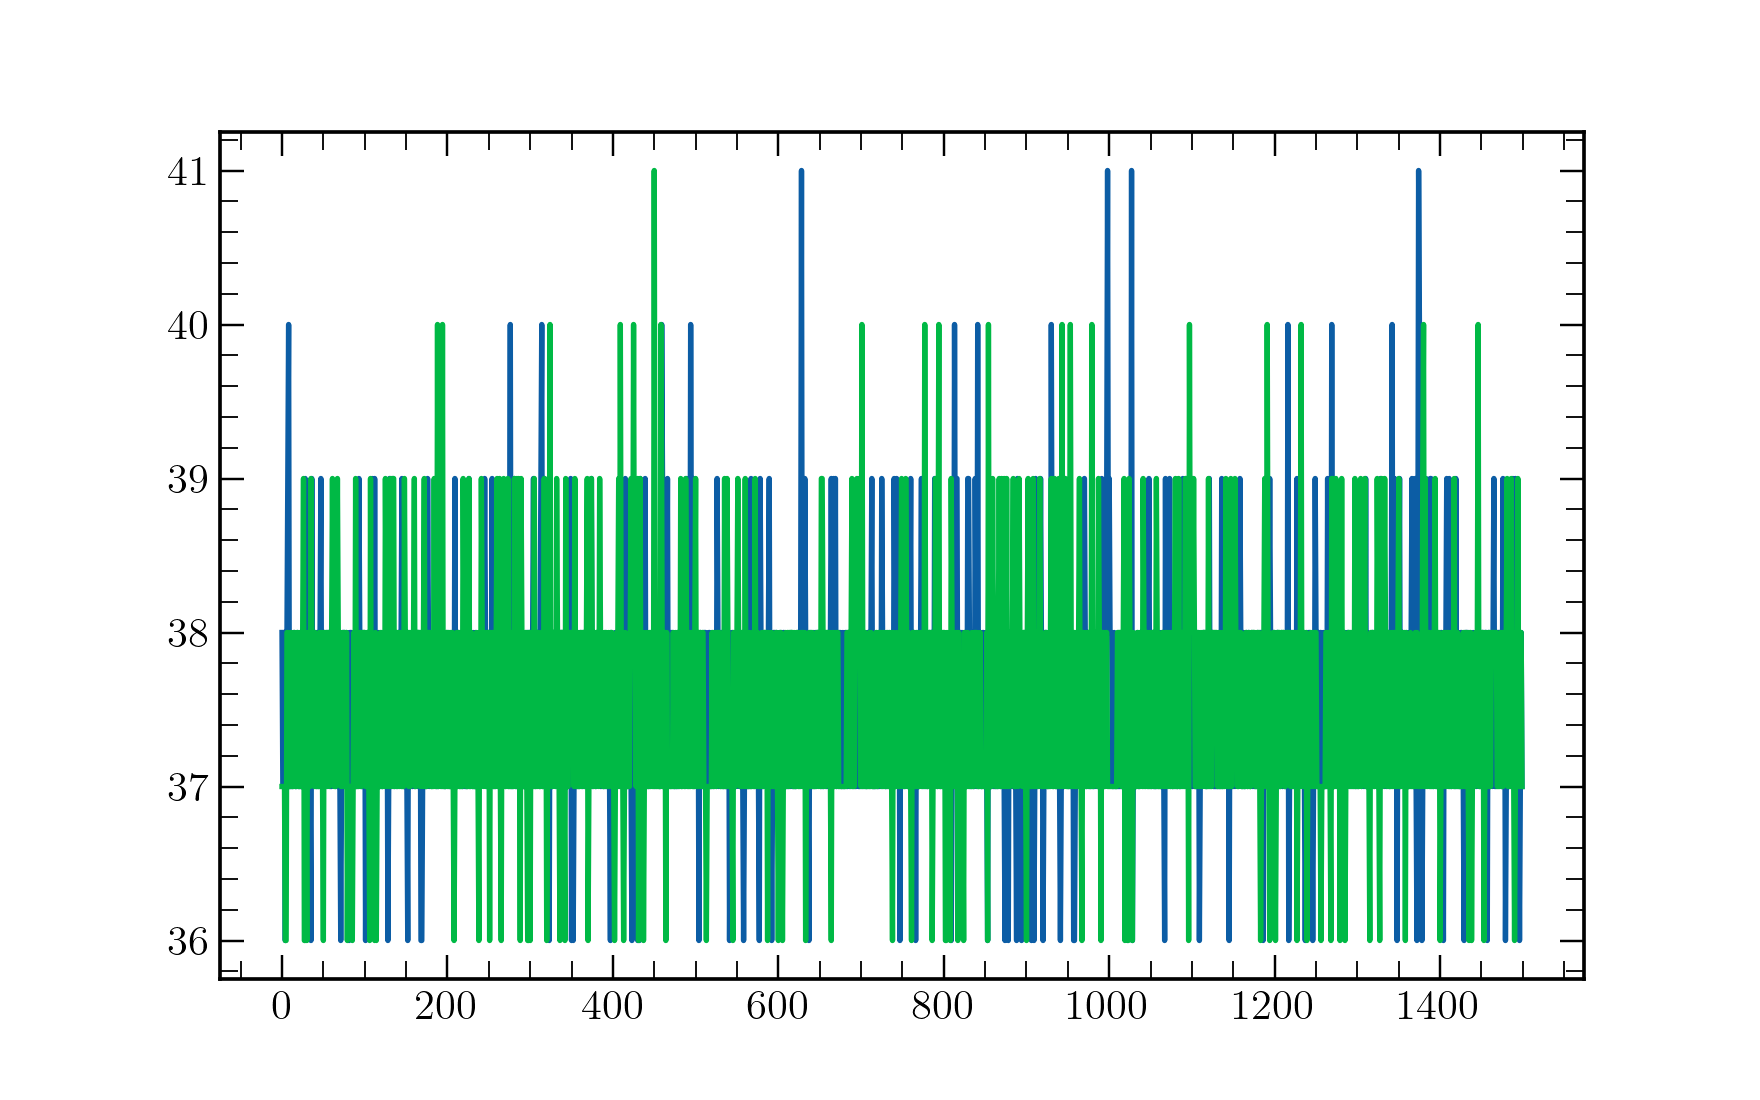

In [41]:
plt.figure()
plt.plot(niter['nn'].T)
plt.plot(niter['ee'].T)

In [42]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

<IPython.core.display.Javascript object>


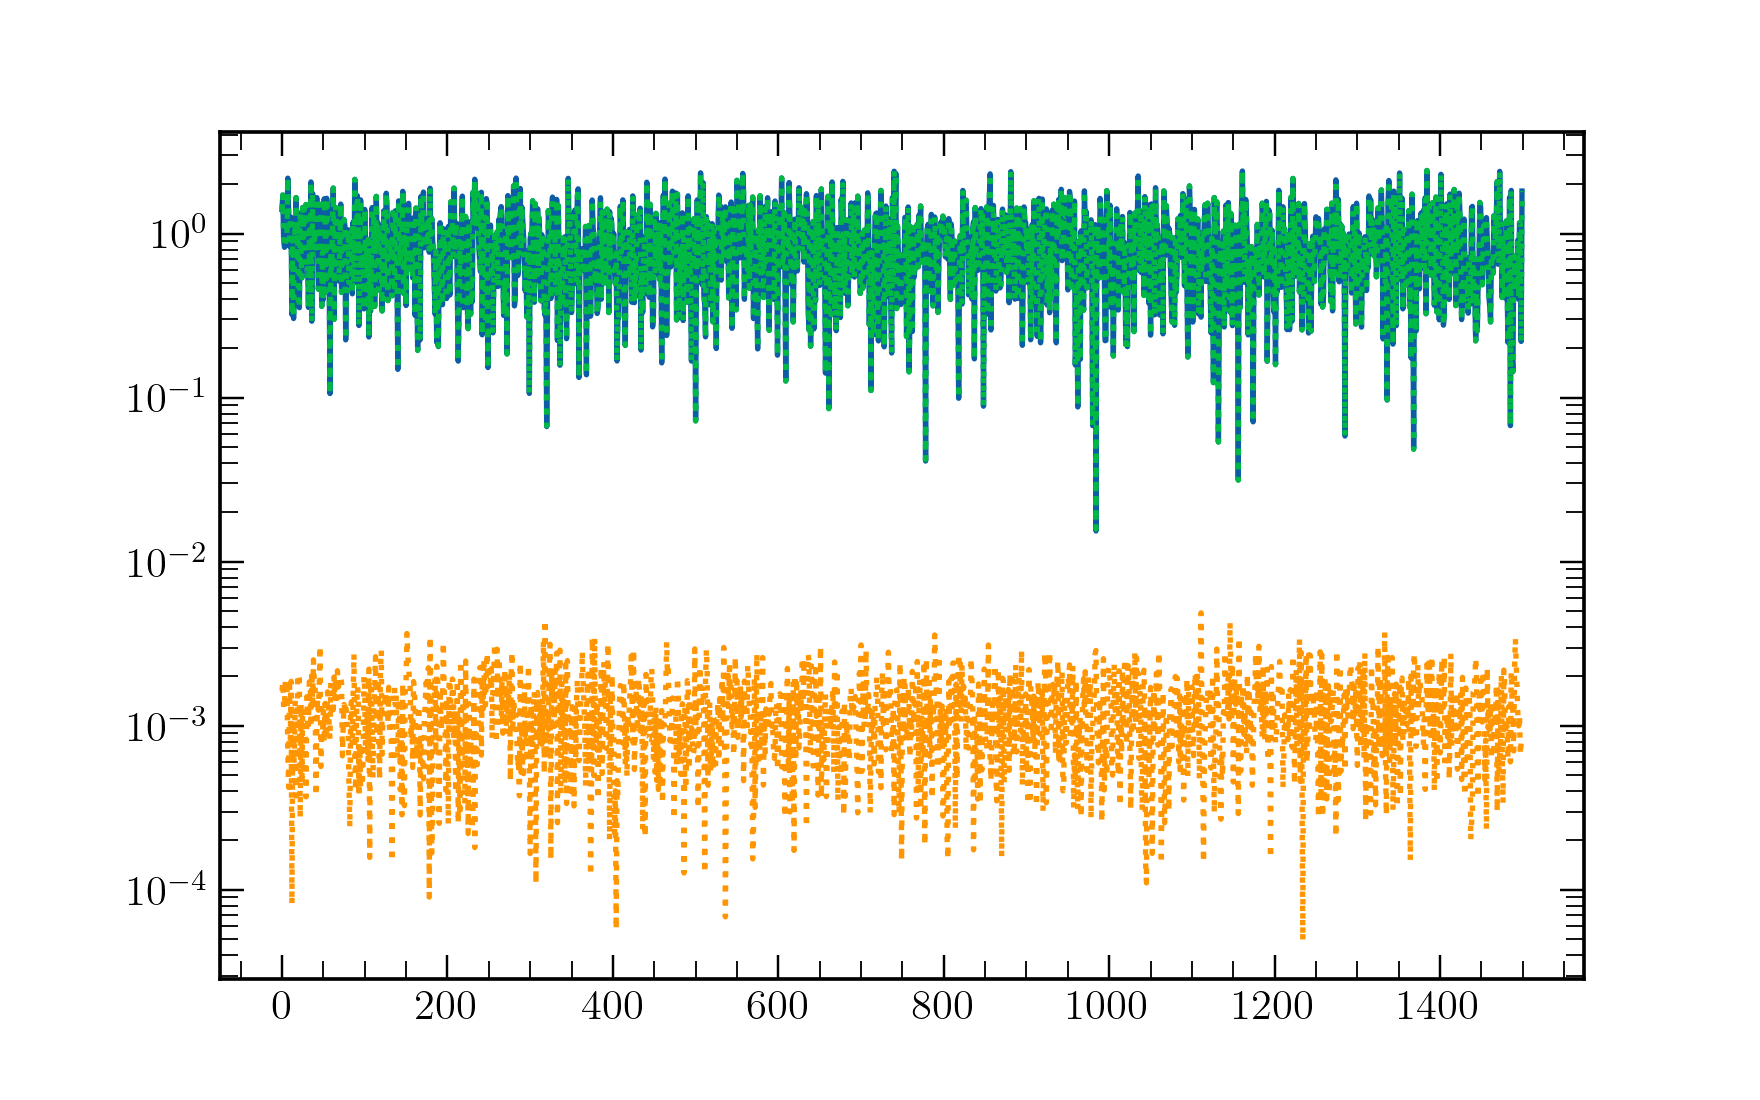

In [43]:
plt.figure()
plt.semilogy(np.abs(model_vis[0, 3, 'nn'][0]), label='Truth')
plt.semilogy(np.abs(data_vis_copy[0, 3, 'nn'][0]), ls=':', label='Calibrated Data')
plt.semilogy(np.abs(model_vis[0, 3, 'nn'][0] - data_vis_copy[0, 3, 'nn'][0]), ls=':', label='Residuals')
plt.show()

## Abscal Approach

In [44]:
ants = list(antpos.keys())

In [45]:
%%time
vis_dict_copy = deepcopy(data_vis)
vis_dict_copy = datacontainer.DataContainer(vis_dict_copy)

# Amplitude fit
amp_fit = abscal.amp_logcal(model_vis, vis_dict_copy, verbose=False)    
phs_fit = abscal.phs_logcal(model_vis, vis_dict_copy, verbose=False)

gains = {}
for k in antpos:
    gains[(k, 'Jnn')] = np.exp(amp_fit[f'eta_{k}_Jnn'] + 1j * phs_fit[f'phi_{k}_Jnn'])
    gains[(k, 'Jee')] = np.exp(amp_fit[f'eta_{k}_Jee'] + 1j * phs_fit[f'phi_{k}_Jee'])
    
apply_cal.calibrate_in_place(vis_dict_copy, gains)

CPU times: user 3min 58s, sys: 56.6 s, total: 4min 54s
Wall time: 2min 43s


<IPython.core.display.Javascript object>


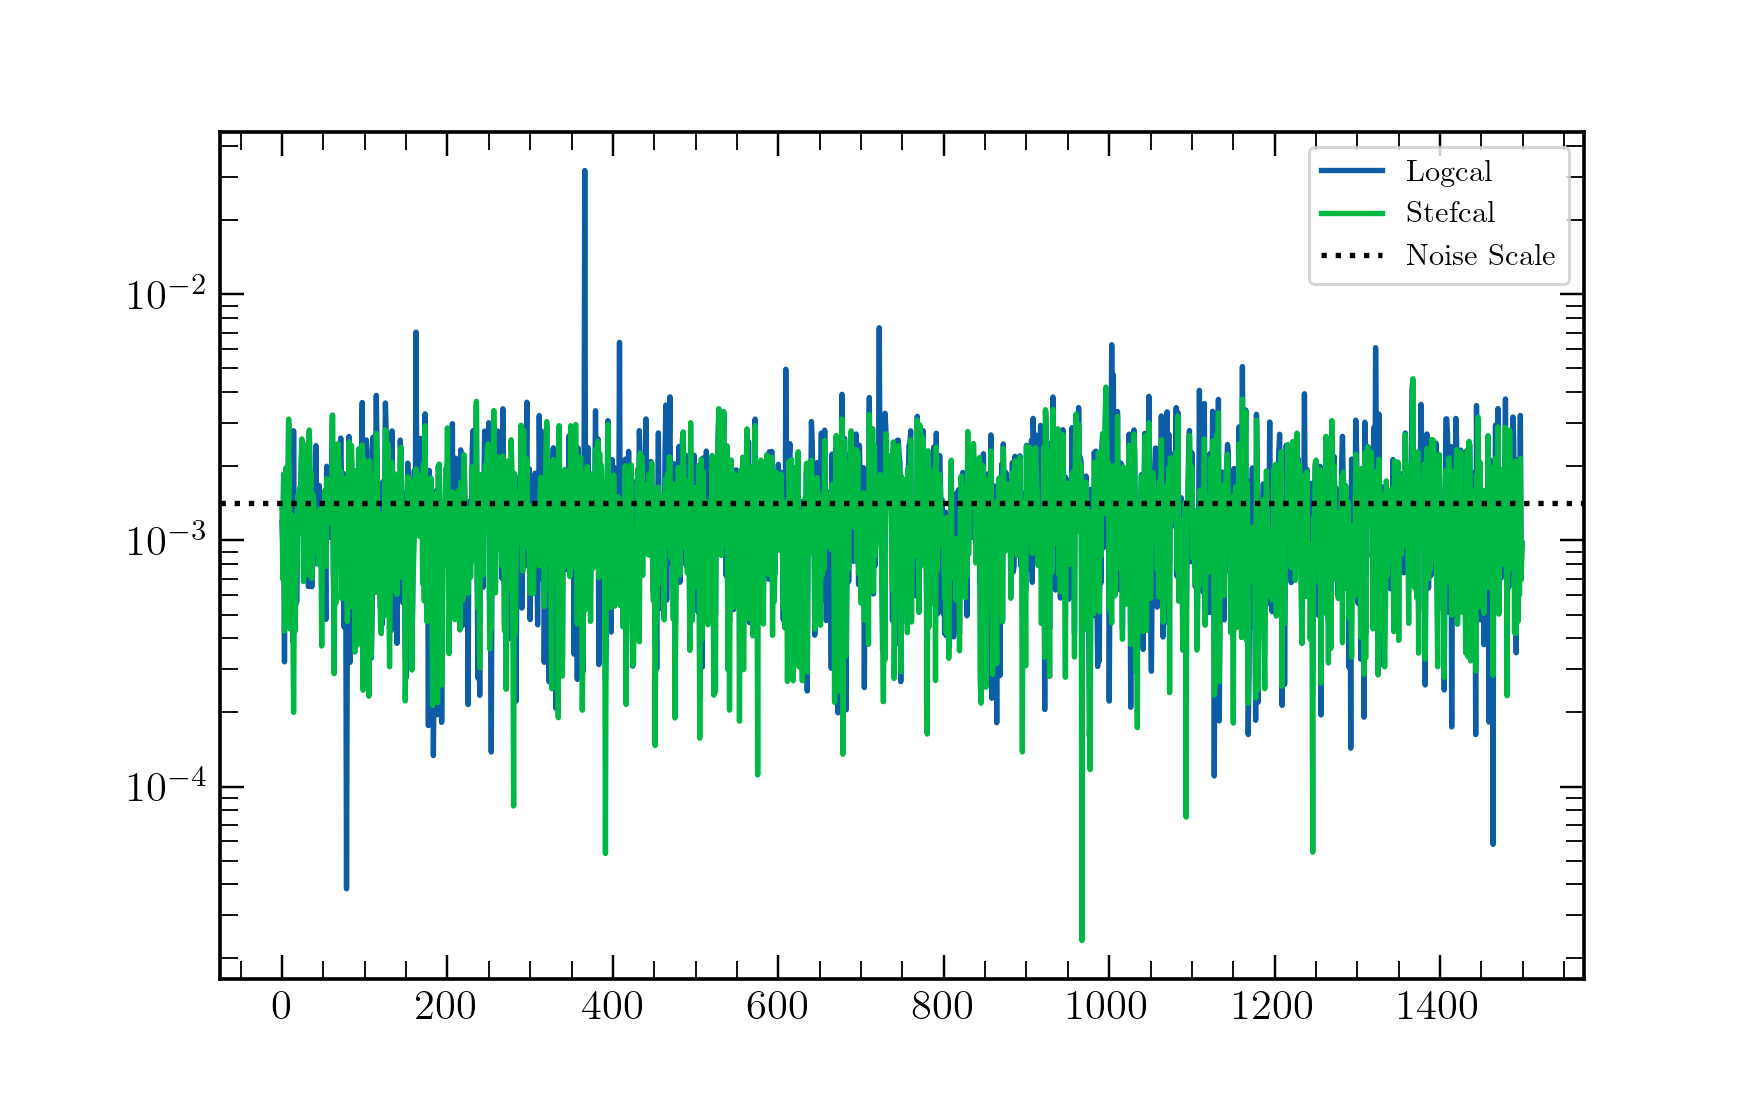

In [47]:
plt.figure()
plt.semilogy(np.abs(vis_dict_copy[(0, 2, 'nn')][0] - model_vis[(0, 2, 'nn')][0]), ls='-', label='Logcal')
plt.semilogy(np.abs(data_vis_copy[0, 2, 'nn'][0] - model_vis[0, 2, 'nn'][0]), ls='-', label='Stefcal')
plt.axhline(noise_scale * np.sqrt(2), color='k', ls=':', label='Noise Scale')
plt.legend()
plt.show()

In [53]:
nfreqs = 100
antpos = hex_array(3, split_core=True, outriggers=0)
reds = redcal.get_reds(antpos)
gains, model_vis, data_vis = vis.sim_red_data(reds, shape=(1, nfreqs))
model_vis = datacontainer.RedDataContainer(model_vis, reds=reds)
data_vis = datacontainer.DataContainer(data_vis)
flags = datacontainer.DataContainer({k: np.zeros(data_vis[k].shape, dtype=bool) for k in data_vis})

# Test that the function runs
gains, niter, conv_crit = calibration.sky_calibration(
    data_vis, model_vis, flags, maxiter=1000, tol=1e-10, stepsize=0.5
)

apply_cal.calibrate_in_place(data_vis, gains)

/usr/local/anaconda3/lib/python3.8/site-packages/hera_sim/noise.py:243: UserWarning: white_noise is being deprecated. Use utils.gen_white_noise instead.
  warnings.warn("white_noise is being deprecated. Use utils.gen_white_noise instead.")


In [63]:
for k in data_vis:
    np.testing.assert_array_almost_equal(data_vis[k], model_vis[k])